In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams['text.usetex'] = False
plt.rcParams["figure.autolayout"] = True

def axbut1(a):
    return tuple(range(len(a.shape) - 1))

def summary(run, ref=None, color='green', name=None):
    p1 = run.posterior
    if ref:
        p0 = ref.posterior
    with np.printoptions(precision=3):
        print(    f"Seasonality:  {np.quantile(p1.seasonality_beta1.values, (0.25, 0.5, 0.75), axis=(0,1))}")
        if ref:
            print(f" ref:         {np.quantile(p0.seasonality_beta1.values, (0.25, 0.5, 0.75), axis=(0,1))}")
        print(    f"exp(Alpha_i): {np.median(np.exp(-p1.alpha_i.values), axis=(0,1))}")
        if ref:
            print(f" exp(ref):    {np.median(np.exp(-p0.alpha_i.values), axis=(0,1))}")

    days = np.arange(214, 214+p1.seasonality_multiplier.shape[-1])
    plt.figure(figsize=(4, 3))
    if 'seasonality_year' in run.posterior:
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 2, 1)
    plt.xlabel("day of year (wraps around at 365)")
    plt.ylabel("seasonal multiplier")
    plt.xticks([214, 250, 300, 350, days[-1]])
    for q in [0.025, 0.25, 0.5, 0.75, 0.925]:
        plt.plot(days, np.quantile(p1.seasonality_multiplier, q, axis=axbut1(p1.seasonality_multiplier)),
                 color, linewidth=(1.3 if q == 0.5 else 0.4))
        if ref:
            plt.plot(days, np.quantile(p0.seasonality_multiplier, q, axis=axbut1(p0.seasonality_multiplier)),
                     "k", linewidth=(1.3 if q == 0.5 else 0.4))
            
    if 'seasonality_year' in run.posterior:
        plt.subplot(1, 2, 2)
        plt.xlabel("day of year (periodic)")
        plt.xticks([0, 91, 182, 273, 364])
        for q in [0.025, 0.25, 0.5, 0.75, 0.925]:
            plt.plot(np.quantile(p1.seasonality_year, q, axis=axbut1(p1.seasonality_year)),
                     color, linewidth=(1.3 if q == 0.5 else 0.4))
            if ref:
                rc = 1 + p0.seasonality_beta1.values.reshape(-1, 1) * np.cos(np.arange(0,365).reshape(1,-1) / 365 * 2 * np.pi)
                plt.plot(np.quantile(rc, q, axis=0), "k", linewidth=(1.3 if q == 0.5 else 0.4))
    
    if name:
        plt.savefig(f"figures/appendix/sensitivity-fi/fig-seasonal-curve-{name}.pdf")
            
def yearly_curve(data, exp=2):
    sin = np.sin(np.arange(0, 2*np.pi, 0.001))
    sin_L2 = np.mean(np.abs(sin) ** exp) ** (1/exp)
    data_L2 = (np.mean(np.abs(data) ** exp, axis=-1) ** (1/exp)).flatten()
    ratio = data_L2 / sin_L2
    #sns.kdeplot(ratio)
    #plt.plot([np.median(ratio)]*2, [0, 10], 'r')
    sns.violinplot(x=ratio, linewidth=1.0, inner="quartiles")
    print(f"Median {np.median(ratio)}, quartiles {np.quantile(ratio, [0.25, 0.75])}")

## Full run - default seasonality

Default seasonality
Seasonality:  [0.246 0.272 0.297]
exp(Alpha_i): [0.824 0.842 0.978 0.885 0.853 0.995 1.035 0.931 0.934 1.006 0.974 0.996
 0.929 0.991 0.835 0.988 0.976 1.02  0.832]


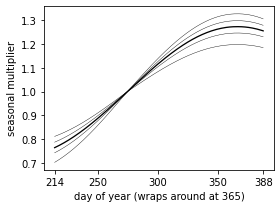

In [2]:
print("Default seasonality")
Ls=az.from_netcdf('../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality/20220616-232520-31123_full.netcdf')
summary(Ls, color='k', name="base")


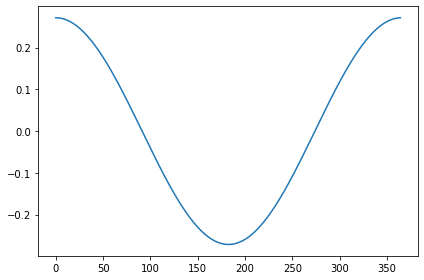

In [3]:
plt.plot(Ls.posterior.seasonality_beta1.values.mean() * np.cos(np.arange(0,365) / 365 * 2 * np.pi))

## Full runs - interactions

Interactions with seasonal sine wave

Seasonality:  [0.24  0.259 0.278]
 ref:         [0.246 0.272 0.297]
exp(Alpha_i): [0.911 0.568 0.973 0.823 0.951 1.001 1.083 0.904 0.972 0.992 0.997 0.985
 0.961 0.995 0.927 1.007 0.997 0.981 0.871]
 exp(ref):    [0.824 0.842 0.978 0.885 0.853 0.995 1.035 0.931 0.934 1.006 0.974 0.996
 0.929 0.991 0.835 0.988 0.976 1.02  0.832]
Interactions: [-1.005 -2.719 -0.524 -0.169  0.26   0.329  0.088 -0.722  0.88  -1.556
  0.772  0.511  1.282 -1.448  1.766  0.377  0.948 -1.241  0.896] (note: logspace interactions)


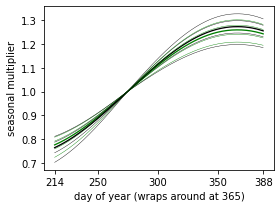

In [4]:
print("Interactions with seasonal sine wave\n")
Li1=az.from_netcdf('../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_interactions/20220617-101845-54280_full.netcdf')
summary(Li1, ref=Ls, name="interactions")
with np.printoptions(precision=3):
    print(f"Interactions: {np.median(Li1.posterior.alpha_int_i.values, axis=(0,1))} (note: logspace interactions)")

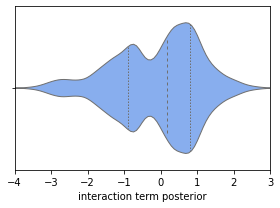

In [5]:
plt.figure(figsize=(4, 3))
a_i=np.array([-1.005, -2.719, -0.524, -0.169,  0.26,   0.329,  0.088, -0.722,  0.88,  -1.556,
0.772,  0.511,  1.282, -1.448,  1.766,  0.377,  0.948, -1.241,  0.896])
ax=sns.violinplot(x=Li1.posterior.alpha_int_i.values, linewidth=1.0, inner="quartiles", color='#7af', cut=0)
ax.set_xlim(-4, 3)
plt.xlabel("interaction term posterior")
plt.savefig("fig-seasonal-interactions-dist.pdf")

In [6]:
#print("Interactions with full sine wave\n")
#Li2=az.from_netcdf('../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_interactions/20220617-101918-54377_full.netcdf')
#summary(Li2, ref=Ls)
#with np.printoptions(precision=3):
#    print(f"Interactions: {np.median(Li2.posterior.alpha_int_i.values, axis=(0,1))}  (note: logspace interactions)")

## Full runs - fourier approximations

Fourier degree 1
Seasonality:  [0.246 0.272 0.297]
 ref:         [0.246 0.272 0.297]
exp(Alpha_i): [0.823 0.842 0.978 0.885 0.854 0.995 1.035 0.932 0.935 1.006 0.974 0.996
 0.93  0.99  0.834 0.988 0.976 1.02  0.832]
 exp(ref):    [0.824 0.842 0.978 0.885 0.853 0.995 1.035 0.931 0.934 1.006 0.974 0.996
 0.929 0.991 0.835 0.988 0.976 1.02  0.832]


<Figure size 288x216 with 0 Axes>

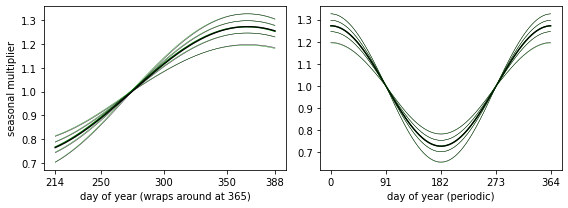

In [14]:
print("Fourier degree 1")
Lf1=az.from_netcdf('../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_fourier/20220616-232550-31300_full.netcdf')
summary(Lf1, ref=Ls, name="fourier1")

In [8]:
#yearly_curve(Lf1.posterior.seasonality_year.values - 1, 2.0)

Fourier degree 2
Seasonality:  [0.388 0.424 0.459]
 ref:         [0.246 0.272 0.297]
exp(Alpha_i): [0.81  0.865 0.969 0.866 0.852 0.991 1.04  0.877 0.919 1.011 0.981 1.002
 0.936 0.995 0.856 1.    0.99  1.01  0.849]
 exp(ref):    [0.824 0.842 0.978 0.885 0.853 0.995 1.035 0.931 0.934 1.006 0.974 0.996
 0.929 0.991 0.835 0.988 0.976 1.02  0.832]


<Figure size 288x216 with 0 Axes>

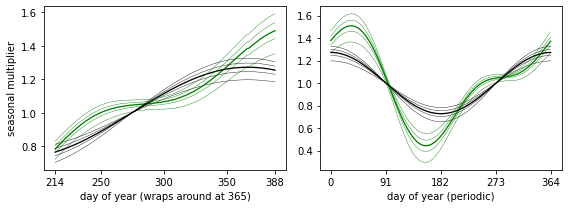

In [9]:
print("Fourier degree 2")
Lf2=az.from_netcdf('../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_fourier/20220616-232558-31424_full.netcdf')
summary(Lf2, ref=Ls, name="fourier2")

In [10]:
#yearly_curve(Lf2.posterior.seasonality_year.values - 1, 2.0)

Fourier degree 3
Seasonality:  [0.106 0.154 0.203]
 ref:         [0.246 0.272 0.297]
exp(Alpha_i): [0.822 0.884 0.971 0.858 0.846 0.992 1.07  0.905 0.899 1.03  0.977 1.004
 0.951 0.992 0.851 1.002 0.999 1.008 0.866]
 exp(ref):    [0.824 0.842 0.978 0.885 0.853 0.995 1.035 0.931 0.934 1.006 0.974 0.996
 0.929 0.991 0.835 0.988 0.976 1.02  0.832]


<Figure size 288x216 with 0 Axes>

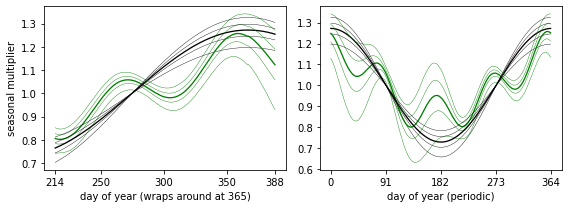

In [11]:
print("Fourier degree 3")
Lf3=az.from_netcdf('../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_fourier/20220619-113807-65280_full.netcdf')
summary(Lf3, ref=Ls, name="fourier3")

In [12]:
#yearly_curve(Lf3.posterior.seasonality_year.values - 1, 2.0)

Fourier degree 4
Seasonality:  [0.038 0.083 0.126]
 ref:         [0.246 0.272 0.297]
exp(Alpha_i): [0.788 0.871 0.962 0.787 0.843 0.999 1.03  0.912 0.954 1.015 0.982 0.993
 0.987 0.949 0.904 0.983 0.992 1.044 0.851]
 exp(ref):    [0.824 0.842 0.978 0.885 0.853 0.995 1.035 0.931 0.934 1.006 0.974 0.996
 0.929 0.991 0.835 0.988 0.976 1.02  0.832]


<Figure size 288x216 with 0 Axes>

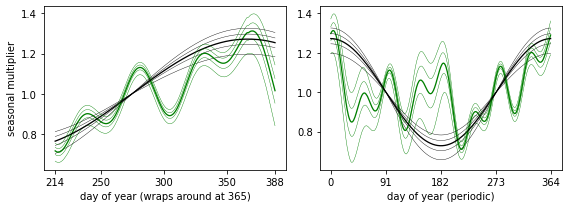

In [13]:
print("Fourier degree 4")
Lf4=az.from_netcdf('../../sensitivity_analysis.2-hold/20220616-232606-31541_full.netcdf')
summary(Lf4, ref=Ls, name="fourier4")